In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pickle

In [2]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [3]:
from dask import dataframe as dd
import joblib
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.scheduler, cluster.workers

C:\Users\bwils\anaconda3\envs\micromotion\lib\site-packages\distributed\node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54606 instead
  warnings.warn(


(<Scheduler: "tcp://127.0.0.1:54609" workers: 4 cores: 8, tasks: 0>,
 {0: <Nanny: tcp://127.0.0.1:54634, threads: 2>,
  1: <Nanny: tcp://127.0.0.1:54642, threads: 2>,
  2: <Nanny: tcp://127.0.0.1:54639, threads: 2>,
  3: <Nanny: tcp://127.0.0.1:54633, threads: 2>})

In [4]:
#read data for modeling
train_X = pd.read_pickle('DFs/train_test/train_X.pkl')
train_y = pd.read_pickle('DFs/train_test/train_y.pkl')
test_X = pd.read_pickle('DFs/train_test/test_X.pkl')
test_y = pd.read_pickle('DFs/train_test/test_y.pkl')

In [5]:
#read in participants lists
f = open(r'DFs/train_test/participants.pkl', 'rb')
participants = pickle.load(f)
f.close()

### Scoring/Predicting Functions
Create functions for scoring, logging and visualizing model tests on the 5 individual test participants

In [6]:
%%writefile model_prep/score.py
def score_model(model, participants, test_y, test_X, log, model_name='Model'):
    #create dataframe of scores, predictions and actual values for visualization and comparison
    
    #import necessary pacakges
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_percentage_error
    import pandas as pd
    import numpy as np
    
    #Create dictionary for visualization
    par_scores = {'par':[],'pred':[], 'true':[],'MAPE':[]}
    
    #cycle through test participants
    for par in participants['test']:
        #Create mask using PID values
        mask = test_y.reset_index(drop=True)['PID']==par
        #Make predictions
        pred_X = test_X[mask,:]
        y_pred = model.predict(pred_X)
        
        #save true values, participant number, predicted values
        y_true = test_y.loc[test_y['PID']==par, 'target_1_sec'].to_numpy()
        par_scores['par'].append(par)
        par_scores['pred'].append(y_pred)
        par_scores['true'].append(y_true)
        
        #score using mean absolute error and mean absolute percentage error
        MAPE = mean_absolute_percentage_error(y_true, y_pred)
        MAE = mean_absolute_error(y_true, y_pred)
        par_scores['MAPE'].append(MAPE)
        
        #Add data to log
        log['par'].append(par)
        log['MAPE'].append(MAPE)
        log['MAE'].append(MAE)
        log['model'].append(model_name)
        for key, value in model.get_params().items():
            log[key].append(value)
        
        #convert dictionary to dataframe
        par_scores_df = pd.DataFrame(par_scores)   
    
    #output updated log and dataframe for visualization
    return par_scores_df, log    

Overwriting model_prep/score.py


In [7]:
%%writefile model_prep/predict.py
def plot_predictions(results, participants, model_name='Model'):
    #visualize predictions for each individual participant 
    
    #import packages
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    #set index to zero
    ind = 0
    
    #cycle through test participants
    for par in participants['test']:
        #Extract predictions and truths from dataframe and combine for plotting
        prediction = results.loc[results['par']==par, 'pred'][ind]
        truth = results.loc[results['par']==par, 'true'][ind]
        compare = pd.DataFrame({'Truth':truth, 'Prediction':prediction})
        
        #plot rolling 10 second mean of predictions and truths 
        compare.rolling(100).mean().plot(figsize=(20,6))
        plt.title('{model} Comparision of Actual to Proposed Participant {par}'.format(model=model_name, par=par))
        plt.xlabel('Time (tenths of a second)')
        plt.ylabel('Movement (mm)')
        plt.text(x=1750, y=7.0, s='MAPE = {}%'.format(int(results['MAPE'][ind]*100)), fontsize='x-large')
        plt.ylim(2.5,15)
        plt.show()
        ind +=1

Overwriting model_prep/predict.py


In [8]:
from model_prep import score_model

In [9]:
from model_prep import plot_predictions

# ElasticNet 10 Components

We can start with an out of the box ElesticNet. We will reduce the 700 plus features to 10 principal components to reduce computation time and hopefully weed out noise.

In [10]:
#create and fit elasticnet and 10 component pca
elastic10 = ElasticNet()
pca10 = PCA(n_components=10)
train_X_pca10 = pca10.fit_transform(train_X)
test_X_pca10 = pca10.transform(test_X)
elastic10.fit(train_X_pca10, train_y)

ElasticNet()

In [11]:
#create logging dictionary
elastic_scores = {'model':[],'par':[],'MAPE':[], 'MAE':[]}
for param in elastic10.get_params():
    elastic_scores[param]=[]

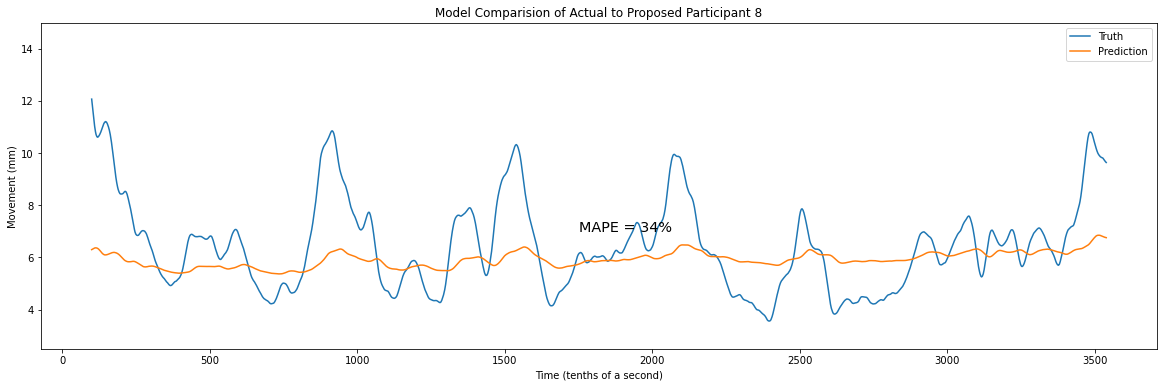

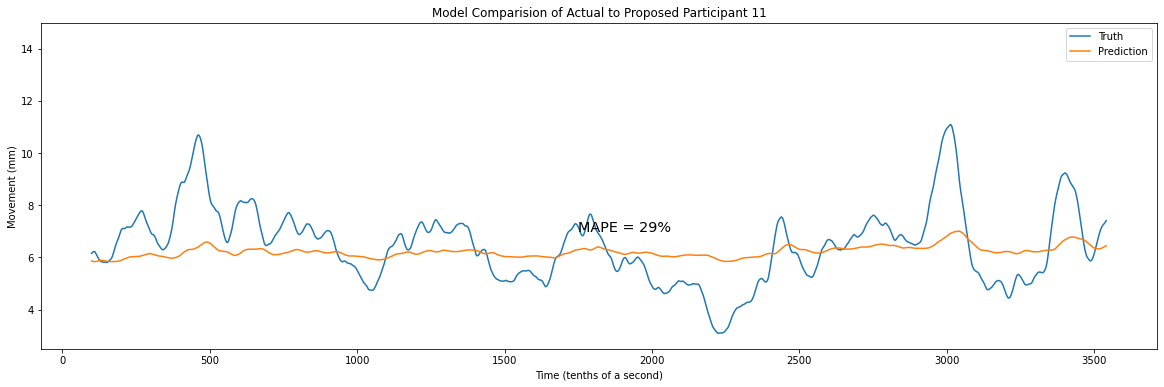

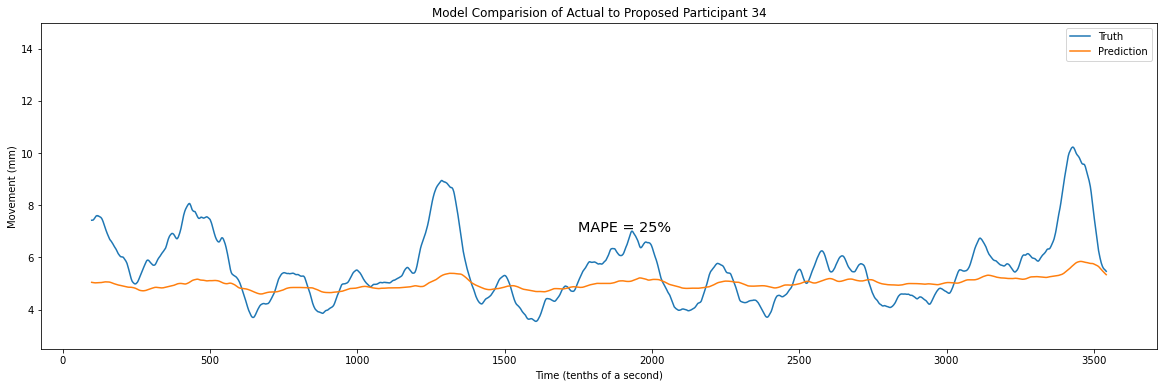

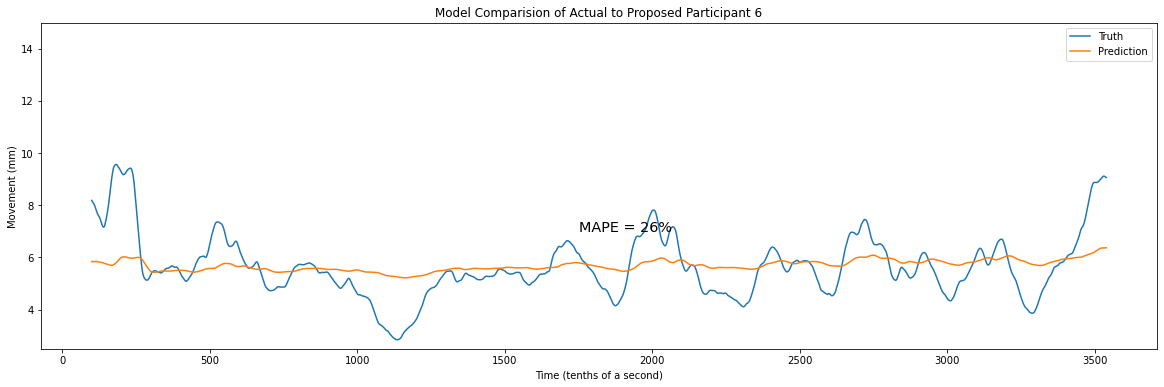

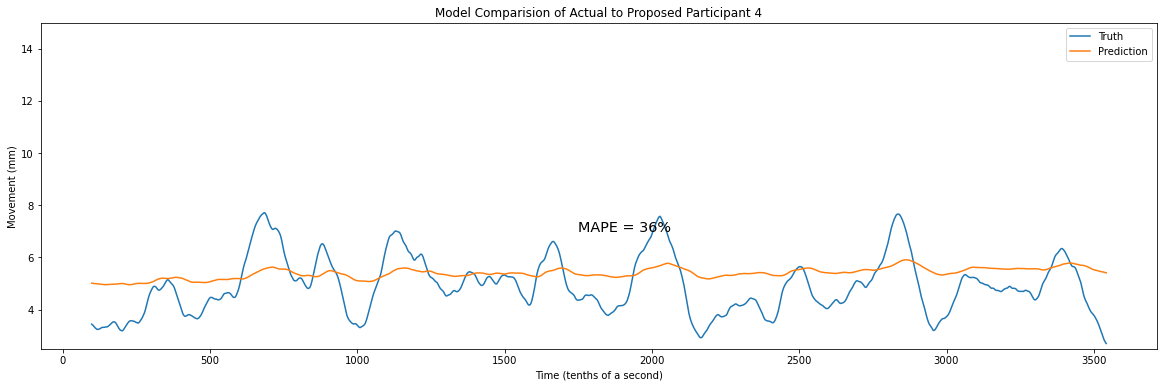

In [12]:
#run functions to log and plot results
results, elastic_scores = score_model(elastic10, participants=participants, test_y=test_y, test_X=test_X_pca10, 
                      model_name='ElasticNet10', log = elastic_scores)
plot_predictions(results, participants)

We can see that there is a lot a variantion between participants. The model does seem to pick up the trend of the data, but not quite the amplitude. Let's try using more commponents to see if it increases the models sensitivity to amplitude. 

In [13]:
elastic_scores.keys()

dict_keys(['model', 'par', 'MAPE', 'MAE', 'alpha', 'copy_X', 'fit_intercept', 'l1_ratio', 'max_iter', 'normalize', 'positive', 'precompute', 'random_state', 'selection', 'tol', 'warm_start'])

# ElasticNet 200 Components

In [14]:
#create and fit elasticnet and 200 component pca
elastic200 = ElasticNet()
pca200 = PCA(n_components=200)
train_X_pca200 = pca200.fit_transform(train_X)
test_X_pca200 = pca200.transform(test_X)
elastic200.fit(train_X_pca200, train_y)

ElasticNet()

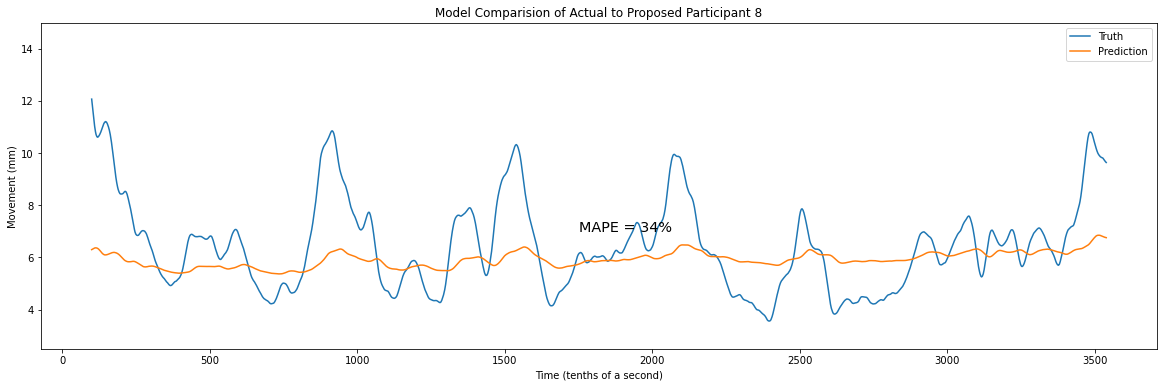

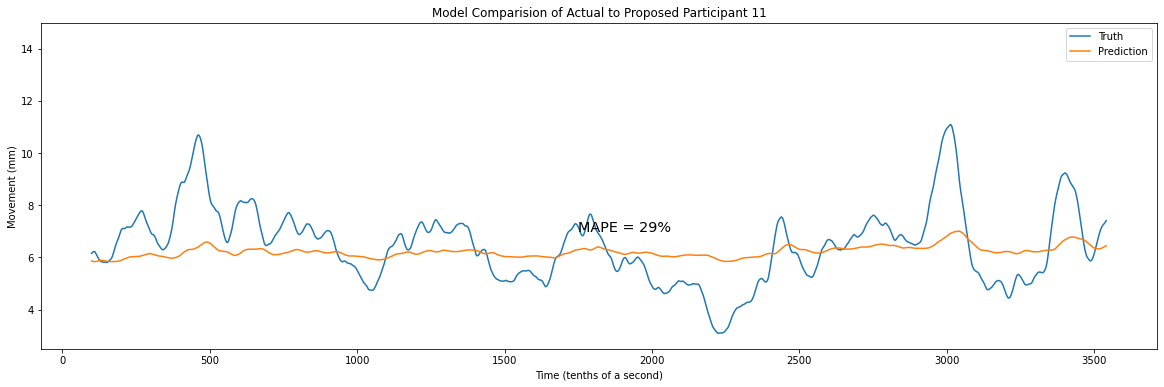

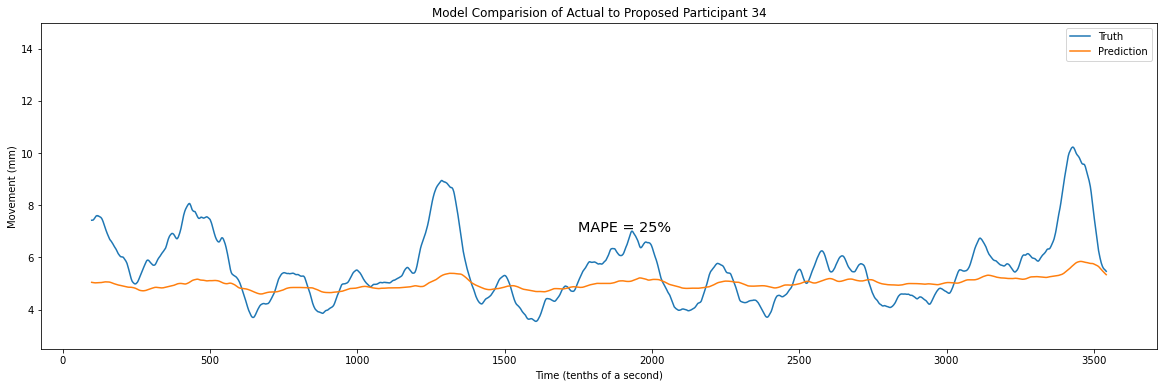

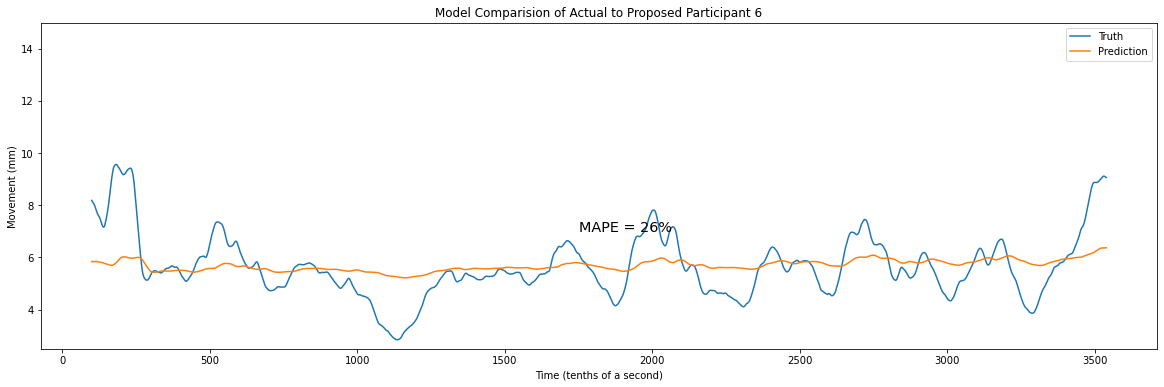

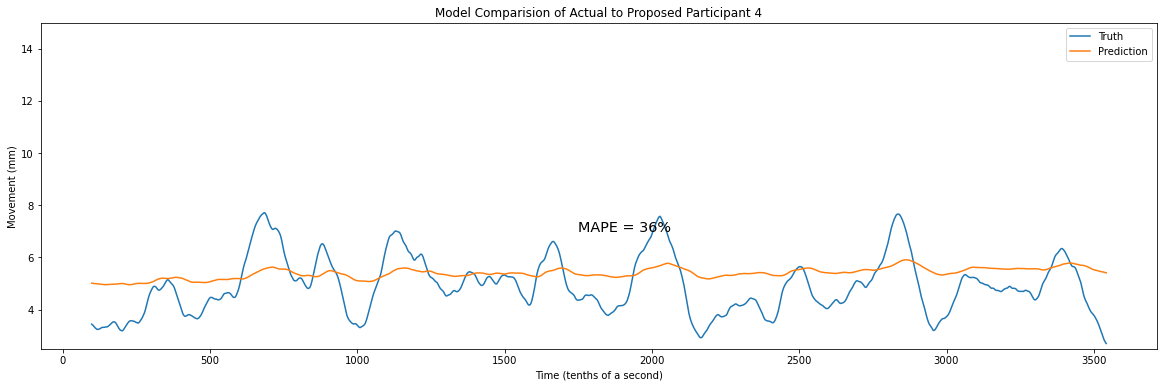

In [15]:
#run functions to log and plot results
results, elastic_scores = score_model(elastic200, participants=participants, test_y=test_y, test_X=test_X_pca200, 
                     model_name='Elastic200', log = elastic_scores)
plot_predictions(results, participants)

There is no notable improvement here. Before deciding to move forward with on the 50 components, lets try using all the components.

# ElasticNet All Components

In [16]:
#create and fit elasticnet and 200 component pca
elastic = ElasticNet()
elastic.fit(train_X, train_y)

ElasticNet()

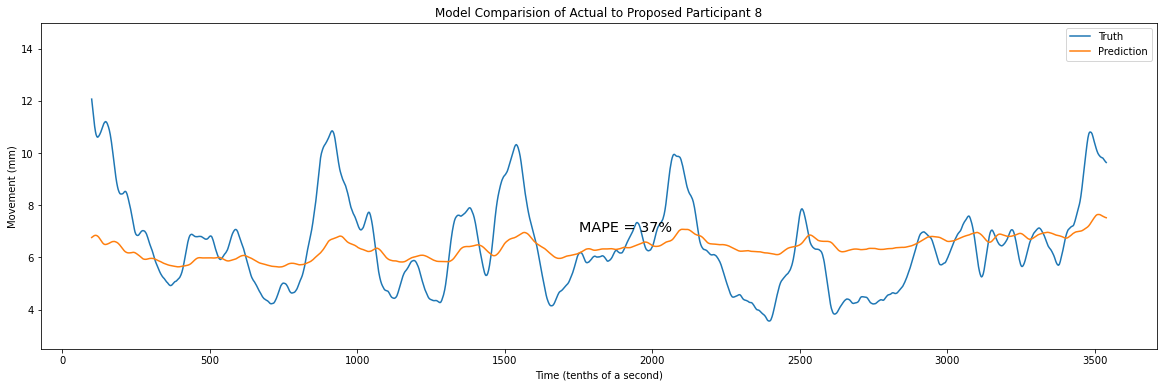

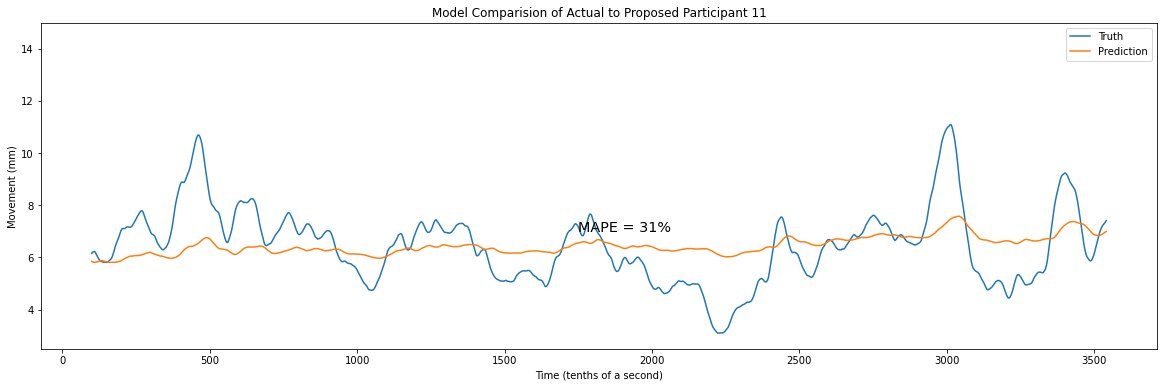

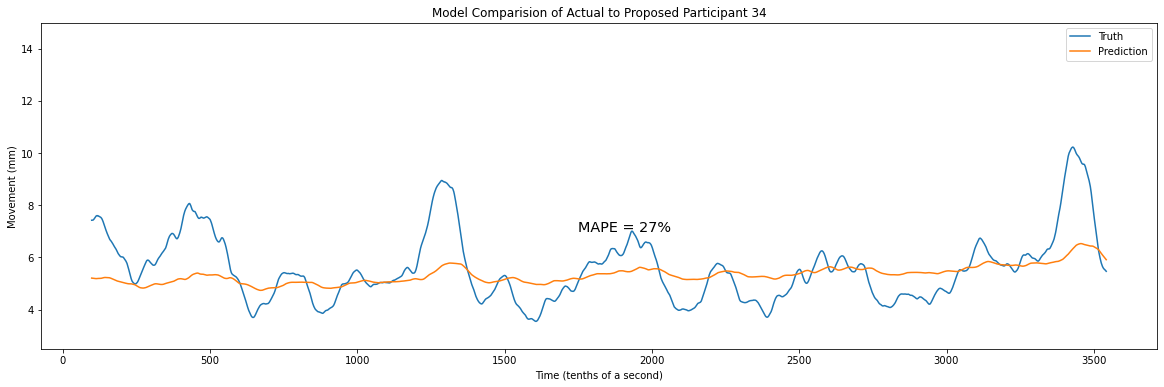

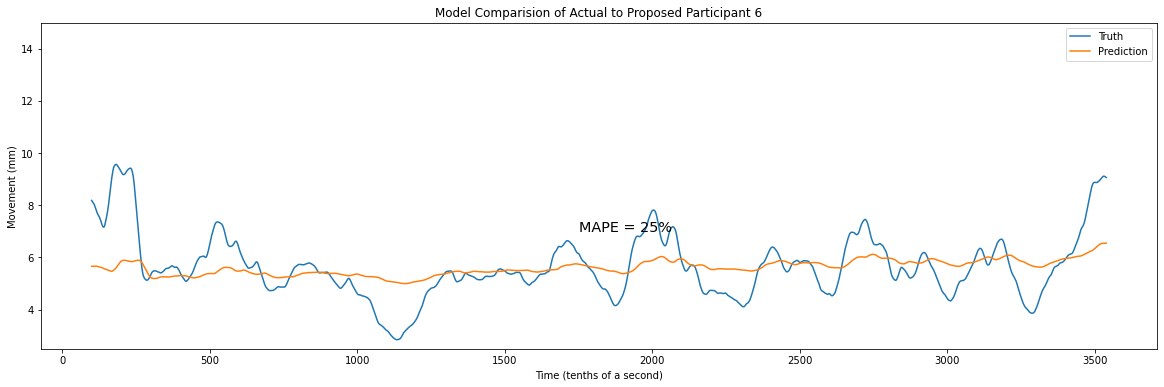

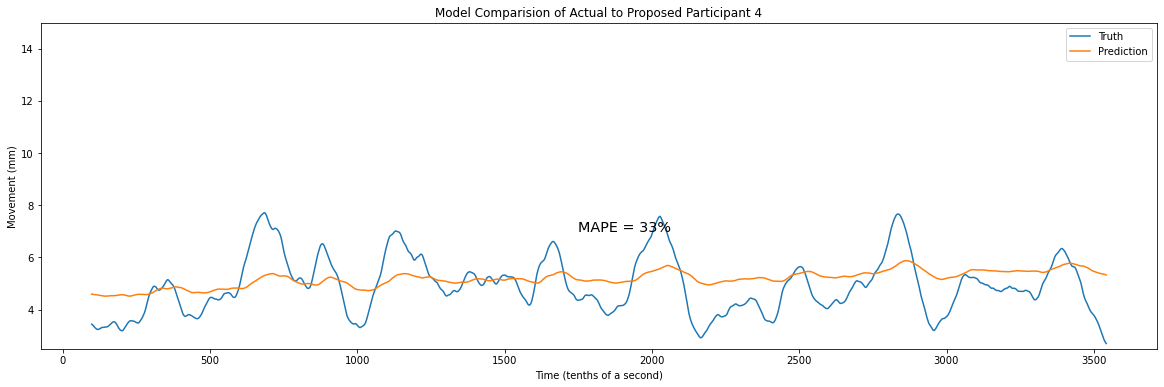

In [17]:
#run functions to log and plot results
results, elastic_scores = score_model(elastic, participants=participants, test_y=test_y, test_X=test_X.to_numpy(), 
                     model_name='ElasticAll', log = elastic_scores)
plot_predictions(results, participants)

We actually get slightly worse here, about 1% increase in error. We will keep with the 50 component PCA to give a balance of computation time and amount of data. Overall Elasticnet seems to perform well. further paramter tuning could lead to better picking up the amplitude and a reduction in error.

In [18]:
#convert logging dictionary to dataframe
elastic_df = pd.DataFrame(elastic_scores)

In [19]:
#Metrics and parameters for each model run sorted by participant
elastic_df.groupby(['par','model']).mean()

MAPE       MAE  alpha  copy_X  fit_intercept  l1_ratio  \
par model                                                                      
4   Elastic200    0.361276  1.410699    1.0    True           True       0.5   
    ElasticAll    0.333647  1.346034    1.0    True           True       0.5   
    ElasticNet10  0.361276  1.410699    1.0    True           True       0.5   
6   Elastic200    0.264813  1.371651    1.0    True           True       0.5   
    ElasticAll    0.259873  1.366781    1.0    True           True       0.5   
    ElasticNet10  0.264813  1.371651    1.0    True           True       0.5   
8   Elastic200    0.346239  2.136065    1.0    True           True       0.5   
    ElasticAll    0.376798  2.159317    1.0    True           True       0.5   
    ElasticNet10  0.346239  2.136065    1.0    True           True       0.5   
11  Elastic200    0.296571  1.742175    1.0    True           True       0.5   
    ElasticAll    0.311835  1.766995    1.0    True           True       0.5   
    ElasticNet10  0.296571  1.742175    1.0    True           True       0.5   
34  Elastic200    0.256528  1.456308    1.0    True           True       0.5   
    ElasticAll    0.273112  1.453972    1.0    True           True       0.5   
    ElasticNet10  0.256528  1.456308    1.0    True           True       0.5   

                  max_iter  normalize  positive  precompute     tol  \
par model                                                             
4   Elastic200        1000      False     False       False  0.0001   
    ElasticAll        1000      False     False       False  0.0001   
    ElasticNet10      1000      False     False       False  0.0001   
6   Elastic200        1000      False     False       False  0.0001   
    ElasticAll        1000      False     False       False  0.0001   
    ElasticNet10      1000      False     False       False  0.0001   
8   Elastic200        1000      False     False       False  0.0001   
    ElasticAll        1000      False     False       False  0.0001   
    ElasticNet10      1000      False     False       False  0.0001   
11  Elastic200        1000      False     False       False  0.0001   
    ElasticAll        1000      False     False       False  0.0001   
    ElasticNet10      1000      False     False       False  0.0001   
34  Elastic200        1000      False     False       False  0.0001   
    ElasticAll        1000      False     False       False  0.0001   
    ElasticNet10      1000      False     False       False  0.0001   

                  warm_start  
par model                     
4   Elastic200         False  
    ElasticAll         False  
    ElasticNet10       False  
6   Elastic200         False  
    ElasticAll         False  
    ElasticNet10       False  
8   Elastic200         False  
    ElasticAll         False  
    ElasticNet10       False  
11  Elastic200         False  
    ElasticAll         False  
    ElasticNet10       False  
34  Elastic200         False  
    ElasticAll         False  
    ElasticNet10       False

In [20]:
#output log for comparison
elastic_df.to_pickle(r'DFs/scores/elastic.pkl')